In [2]:
from google.colab import drive
drive.mount('/content/drive',force_remount=True)

import pandas as pd 
import numpy as np 
import networkx as nx
from tqdm import tqdm
import string
import nltk
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
!python -m spacy download it_core_news_sm
import spacy
import it_core_news_sm
import ast
nltk.download('stopwords')
nltk.download("punkt")
import matplotlib.pyplot as plt
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
from networkx.algorithms import community
import time, datetime
from datetime import datetime, timedelta
import re
import functools
import itertools
from collections import Counter
path = "drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/GRAPH_IMAGES/"

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3aietf%3awg%3aoauth%3a2.0%3aoob&response_type=code&scope=email%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdocs.test%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive%20https%3a%2f%2fwww.googleapis.com%2fauth%2fdrive.photos.readonly%20https%3a%2f%2fwww.googleapis.com%2fauth%2fpeopleapi.readonly

Enter your authorization code:
··········
Mounted at /content/drive
     |████████████████████████████████| 14.5MB 1.1MB/s 
  Created wheel for it-core-news-sm: filename=it_core_news_sm-2.2.5-cp36-none-any.whl size=14471130 sha256=0b37bae8168b81719188b0e84d68917ec7964721b128b549cd2e79bea57f769c
  Stored in directory: /tmp/pip-ephem-wheel-cache-k826g3co/wheels/a1/01/c2/127ab92cc5e3c7f36b5cd4bff28d1c29c313962a2ba913e720
Successfully built it-core-news-sm
✔ Download and installation successful
You can now load the model via spacy

# PREPROCESSING TESTUALE

In [3]:
pd.set_option('display.max_colwidth', -1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: FutureWarning: Passing a negative integer is deprecated in version 1.0 and will not be supported in future version. Instead, use None to not limit the column width.
  """Entry point for launching an IPython kernel.


In [5]:
df = pd.read_csv("drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/tweet_csv/tweet.csv")
df = df.drop(columns="Unnamed: 0")
df.head()

,id_tweet,time_tweet,retweet_count,user_screen_name,text,retweet_screen_name,type,month,day
0,1214161497821188096,Mon Jan 06 12:27:13 +0000 2020,0,MarcoYera,"Comunque la si pensi, #Zalone riesce ancora una volta a riempire le sale di tutti i cinema italiani. In un settore da anni in grande difficoltà, lui riesce ad attirare spettatori di ogni età e classe sociale. È questa la grande forza di Checco: unire. #ToloTolo https://t.co/mUzLVlPxL0",MarcoYera,ORIGINAL,Jan,6
1,1213559760018116608,Sat Jan 04 20:36:08 +0000 2020,0,ValerioManisi,"Non è ""diverso"" #ToloTolo. Sono i fan di #Zalone che finora non hanno capito un cazz*!",ValerioManisi,ORIGINAL,Jan,4
2,1212844720881389568,Thu Jan 02 21:14:49 +0000 2020,1,arghail2,@matteosalvinimi @marcocf69 Sei in brodo di giugiule e tutta farina del tuo sacco fai solo la vittima na sei contento come #Zalone che parlavano male di #ToloTolo e guarda che successo .non fare la vittima!!💩,arghail2,ORIGINAL,Jan,2
3,1213046175655514112,Fri Jan 03 10:35:20 +0000 2020,11,WomanWithPen,"Ci siete rimasti male ""cari"" Sovranisti=Razzisti\ndei miei stivali😅\n\nLa rosicata dei sovranisti trollati da #ToloTolo di #CheccoZalone\n\nhttps://t.co/6GKEMRVQJv di @neXtquotidiano \n\n#facciamorete ❤️🇮🇹👊 https://t.co/3UJtrKExAQ",anubi_matt,RT_NOQUOTE,Jan,3
4,1212753267475861504,Thu Jan 02 15:11:25 +0000 2020,129,sergimagugliani,Salvini propone #CheccoZalone come senatore a vita dopo aver visto il trailer di #ToloTolo \nIl film si rivela una fantasmagorica presa per il culo del salvinismo \nZalone sparisce dai tweet di bandierini e sovranisti \nPiù esilarante di oggi le comiche,Sydwerehere,RT_NOQUOTE,Jan,2


In [6]:
len(df)

22263

In [0]:
df = df.sort_values(by=['month','day'],ascending=True)

## Hashtag, mentions, link


#### Funzioni per estrarre hashtag, mention e link

In [0]:
def estrai_hashtag(testo):
  listaNuova=[]
  hashtag = re.findall('#(\w+)',testo)
  hashtag = list(dict.fromkeys(hashtag)) #rimozione duplicati

  for i in range(0,len(hashtag)):
    stringa="#"+hashtag[i]
    listaNuova.append(stringa)
    #print(stringa)
  return listaNuova

def estrai_mention(testo):
  listaNuova=[]
  menzione = re.findall('@(\w+)',testo)
  menzione = list(dict.fromkeys(menzione)) #rimozione duplicati
  for i in range(0,len(menzione)):
    stringa="@"+menzione[i]
    listaNuova.append(stringa)
    #print(stringa)
  return listaNuova

def estrai_link(testo):
  url = re.findall('https?://[^\s]+', testo) 
  return url

In [0]:
global punteggiatura
punteggiatura = list(string.punctuation)
altri_simboli = ['“','``','"','£','€','…',' ’','”','«','»']
punteggiatura.append(altri_simboli)
punteggiatura = list(itertools.chain.from_iterable(punteggiatura)) #flat lista

In [0]:
def getEmoticons(tweet):
  emoji = re.findall(r'[^\w\s,]', tweet)
  emoji = [x for x in emoji if x not in punteggiatura]
  return emoji

In [0]:
df['Hashtags']=df['text'].apply(lambda x: estrai_hashtag(x))
df['NHashtag'] = df["Hashtags"].apply(lambda x: len(x))

df['Mentions']=df['text'].apply(lambda x: estrai_mention(x))
df['NMention'] = df["Mentions"].apply(lambda x: len(x))

df['Links']=df['text'].apply(lambda x: estrai_link(x))
df['NLink'] = df["Links"].apply(lambda x: len(x))

In [0]:
df["Emoticon"] = df["text"].apply(lambda x: getEmoticons(x))
df['NEmoticon'] = df["Emoticon"].apply(lambda x: len([x])-1)

##### Distribuzione hashtag

Tweet tolti perchè non inerenti: 693


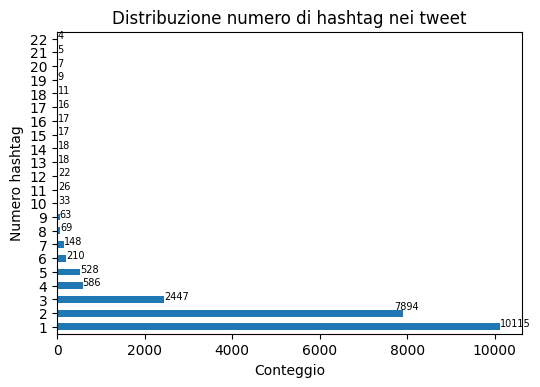

In [0]:
import matplotlib.pyplot as plt
plt.figure(dpi=100)
plt.title("Distribuzione numero di hashtag nei tweet")
df.groupby("NHashtag")["id_tweet"].count().plot(kind="barh")
c = 0
for i in df["NHashtag"].value_counts():
  if c == 1:
    plt.annotate(round(i,2),xy=(i-200,c+0.3),size=7)
  else:
    plt.annotate(round(i,2),xy=(i,c),size=7)
  c+=1

plt.ylabel("Numero hashtag")
plt.xlabel("Conteggio")
plt.savefig('drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/plot/NHashtag.png')

print("Tweet tolti perchè non inerenti:",len(df[df["NHashtag"]>5]))

In [0]:
df = df[df['NHashtag']<=5]
len(df)

21570

In [0]:
def concatena_info(mention,link): #per ogni tweet si concatenano mention e i link presenti nel testo del tweet
  lista=[]
  if len(mention)!=0:
    lista.append(mention)
  if len(link)!=0:
    lista.append(link)
  return list(itertools.chain.from_iterable(lista))

def elimina_info_testo(testo,info,np = False):
  if info is not None:
    for i in range(0,len(info)):
      testo=testo.replace(info[i],' ')
    testo = re.sub(' +', ' ', testo)
  if np == True:
    testo = re.sub('#','',testo) #ora che si hanno solo gli hashtag rilevanti, si considerano gli altri hashtag come parole vere e proprie
  testo.strip()
  return testo

### Pulizia mentions, link nei tweet

In [0]:
df['info']=df.apply(lambda x: concatena_info(x['Mentions'],x['Links']),axis=1)
df['textPreproc']=df.apply(lambda x: elimina_info_testo(x['text'],x['info'],False),axis=1)

In [0]:
df[['text','textPreproc']]

,text,textPreproc
51,#checcozalone e il suo cast now #tolotolo https://t.co/Ga4Z5aJmVk,#checcozalone e il suo cast now #tolotolo
175,@fabio_falzone ...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!
335,"Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre"
337,"#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo."
429,"Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia"
...,...,...
22082,Pena infinita per chi ha pagaro il biglietto del film di #CheccoZalone https://t.co/sL36SFqPFA,Pena infinita per chi ha pagaro il biglietto del film di #CheccoZalone
22135,Forse sono l'unico a non aver visto il film di #Zalone\nLo sapevo\n... io\nSono sempre la solita pecora nera 😁\nVoi l'avete visto tutti vero?\n#ToloTolo,Forse sono l'unico a non aver visto il film di #Zalone\nLo sapevo\n... io\nSono sempre la solita pecora nera 😁\nVoi l'avete visto tutti vero?\n#ToloTolo
22215,@GianniJ08 Ti spiego. Due sono le cose che fanno figo con #ToloTolo: \n1) dire che lo hai visto e che è un capolavoro del cinema mondiale (con annessi e connessi commenti politico-social-filosofico-culturali sul modello niki vendola) \n2) dire che non lo hai visto ... 😅😅,Ti spiego. Due sono le cose che fanno figo con #ToloTolo: \n1) dire che lo hai visto e che è un capolavoro del cinema mondiale (con annessi e connessi commenti politico-social-filosofico-culturali sul modello niki vendola) \n2) dire che non lo hai visto ... 😅😅
22249,#ToloTolo - https://t.co/H9FwDlop3A - storie della visione\n\nResta da domandarsi che cosa #Zalone regista e “autore” abbia voluto dimostrare con il suo film...\nhttps://t.co/znBvJzltiU\n\n#cinema https://t.co/LxhQeBwJQE,#ToloTolo - - storie della visione\n\nResta da domandarsi che cosa #Zalone regista e “autore” abbia voluto dimostrare con il suo film...\n \n\n#cinema


In [0]:
def sistema_hashtag(token_lista, token,pos):
  if token=='#':
    token='§'
  else:
    if token_lista[pos-1]=='#':
      token='#'+token
  #print(token)
  return token

In [0]:
df['token'] = df['textPreproc'].apply(lambda x: word_tokenize(x,language='italian'))
df['index'] = df['token'].apply(lambda x: range(0,len(x)))

In [0]:
df[['textPreproc','token']].head(2)

,textPreproc,token
51,#checcozalone e il suo cast now #tolotolo,"[#, checcozalone, e, il, suo, cast, now, #, tolotolo]"
175,...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,"[..., e, allora, bisogna, correre, a, vederlo, #, tolotolo, #, CheccoZalone, #, Tg2000, #, TV2000, !]"


In [0]:
def elimina_simbolo(token):
  token=[x for x in token if x!='§']
  return token

In [0]:
df['token']=df.apply(lambda x: list(map(functools.partial(sistema_hashtag, x['token']),x['token'],x['index'])),axis=1)
df['token']=df['token'].apply(lambda x: elimina_simbolo(x))

In [0]:
df[['text','textPreproc','token']].head()

,text,textPreproc,token
51,#checcozalone e il suo cast now #tolotolo https://t.co/Ga4Z5aJmVk,#checcozalone e il suo cast now #tolotolo,"[#checcozalone, e, il, suo, cast, now, #tolotolo]"
175,@fabio_falzone ...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,"[..., e, allora, bisogna, correre, a, vederlo, #tolotolo, #CheccoZalone, #Tg2000, #TV2000, !]"
335,"Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","[Ciò, che, difendiamo, è, la, libertà, di, #CheccoZalone, e, di, chiunque, altro, ,, di, sfottere, tutti, nel, modo, che, ritenuto, migliore, senza, le, vostre, rotture, di, cazzo, !, #27dicembre]"
337,"#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","[#CheccoZalone, presenta, 'Tolo, Tolo, ', :, ``, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, Salvini, '', ., E, adesso, chiudete, gli, occhi, e, provate, a, immaginare, la, faccia, da, babbei, di, tutti, i, bandierini, e, del, loro, idolo, ,, che, hanno, difeso, Zalone, fino, a, ieri, e, che, ora, devono, cominciare, a, insultarlo, .]"
429,"Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","[Ideali, di, sinistra.., Uscito, il, video, di, #CheccoZalone, aiuto, help, allarme, rassismo, video, pro, #SALVINI.In, conferenza, stampa, si, dice, che, anzi, è, il, contrario, il, film, è, antisalvini, allora, ok, tutti, a, vedere, #ToloTolo, da, non, perdere, ,, abbiamo, trasmesso, #disagiedintorni, #staseraitalia]"


### Divisione simboli (escluso hashtag)

In [0]:
def separa_simbolo(token,simboli,carattere,pos):
  if carattere==simboli:
    carattere = ' '+carattere+' '
  #print("carattere: "+carattere)
  return carattere


def separa_simboli_token(token):
  simboli = re.findall(r'[+=/.]', token)
  simboli = list(set(simboli))
  if len(simboli)!=0:
    pos=range(0,len(token))
    stringa = list(map(functools.partial(separa_simbolo,token,simboli[0]),token,pos))
    stringa = ''.join(stringa)
    token=stringa
    token = token.split(' ')
  else:
    token=[token]
  return token

In [0]:
df['token'] = df['token'].apply(lambda x: list(map(separa_simboli_token, x)))
df['token'] = df['token'].apply(lambda x: list(itertools.chain(*x)))

In [0]:
df[['text','textPreproc','token']]

,text,textPreproc,token
51,#checcozalone e il suo cast now #tolotolo https://t.co/Ga4Z5aJmVk,#checcozalone e il suo cast now #tolotolo,"[#checcozalone, e, il, suo, cast, now, #tolotolo]"
175,@fabio_falzone ...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,"[, ., , ., , ., , e, allora, bisogna, correre, a, vederlo, #tolotolo, #CheccoZalone, #Tg2000, #TV2000, !]"
335,"Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","[Ciò, che, difendiamo, è, la, libertà, di, #CheccoZalone, e, di, chiunque, altro, ,, di, sfottere, tutti, nel, modo, che, ritenuto, migliore, senza, le, vostre, rotture, di, cazzo, !, #27dicembre]"
337,"#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","[#CheccoZalone, presenta, 'Tolo, Tolo, ', :, ``, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, Salvini, '', , ., , E, adesso, chiudete, gli, occhi, e, provate, a, immaginare, la, faccia, da, babbei, di, tutti, i, bandierini, e, del, loro, idolo, ,, che, hanno, difeso, Zalone, fino, a, ieri, e, che, ora, devono, cominciare, a, insultarlo, , ., ]"
429,"Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","[Ideali, di, sinistra, ., , ., , Uscito, il, video, di, #CheccoZalone, aiuto, help, allarme, rassismo, video, pro, #SALVINI, ., In, conferenza, stampa, si, dice, che, anzi, è, il, contrario, il, film, è, antisalvini, allora, ok, tutti, a, vedere, #ToloTolo, da, non, perdere, ,, abbiamo, trasmesso, #disagiedintorni, #staseraitalia]"
...,...,...,...
22082,Pena infinita per chi ha pagaro il biglietto del film di #CheccoZalone https://t.co/sL36SFqPFA,Pena infinita per chi ha pagaro il biglietto del film di #CheccoZalone,"[Pena, infinita, per, chi, ha, pagaro, il, biglietto, del, film, di, #CheccoZalone]"
22135,Forse sono l'unico a non aver visto il film di #Zalone\nLo sapevo\n... io\nSono sempre la solita pecora nera 😁\nVoi l'avete visto tutti vero?\n#ToloTolo,Forse sono l'unico a non aver visto il film di #Zalone\nLo sapevo\n... io\nSono sempre la solita pecora nera 😁\nVoi l'avete visto tutti vero?\n#ToloTolo,"[Forse, sono, l'unico, a, non, aver, visto, il, film, di, #Zalone, Lo, sapevo, , ., , ., , ., , io, Sono, sempre, la, solita, pecora, nera, 😁, Voi, l'avete, visto, tutti, vero, ?, #ToloTolo]"
22215,@GianniJ08 Ti spiego. Due sono le cose che fanno figo con #ToloTolo: \n1) dire che lo hai visto e che è un capolavoro del cinema mondiale (con annessi e connessi commenti politico-social-filosofico-culturali sul modello niki vendola) \n2) dire che non lo hai visto ... 😅😅,Ti spiego. Due sono le cose che fanno figo con #ToloTolo: \n1) dire che lo hai visto e che è un capolavoro

In [0]:
def separa_emoticon_token(token):
    token_cod=[]
    token = token.replace("🇮🇹",'')
    emoji = re.findall(r'[^\w\s,]', token)
    if '#' in emoji:
        emoji = [x for x in emoji if x != '#']

    if len(emoji)!=0: #esiste emoticon
        parole = re.split(r'[^\w\s,]',token)
        token_cod.append(emoji)
        token_cod.append(parole)
        token_cod=list(itertools.chain(*token_cod))
        token_cod=list(filter(None,token_cod))
    else:
        token_cod.append(token)
    return token_cod

In [0]:
df['token'] = df['token'].apply(lambda x: list(map(separa_emoticon_token, x)))
df['token'] = df['token'].apply(lambda x: list(itertools.chain(*x)))

In [0]:
df['token'] = df['token'].apply(lambda x: list(filter(None,x)))

In [0]:
df[['text','textPreproc','token']].head()

,text,textPreproc,token
51,#checcozalone e il suo cast now #tolotolo https://t.co/Ga4Z5aJmVk,#checcozalone e il suo cast now #tolotolo,"[#checcozalone, e, il, suo, cast, now, #tolotolo]"
175,@fabio_falzone ...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,"[., ., ., e, allora, bisogna, correre, a, vederlo, #tolotolo, #CheccoZalone, #Tg2000, #TV2000, !]"
335,"Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","[Ciò, che, difendiamo, è, la, libertà, di, #CheccoZalone, e, di, chiunque, altro, ,, di, sfottere, tutti, nel, modo, che, ritenuto, migliore, senza, le, vostre, rotture, di, cazzo, !, #27dicembre]"
337,"#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","[#CheccoZalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, Salvini, ', ', ., E, adesso, chiudete, gli, occhi, e, provate, a, immaginare, la, faccia, da, babbei, di, tutti, i, bandierini, e, del, loro, idolo, ,, che, hanno, difeso, Zalone, fino, a, ieri, e, che, ora, devono, cominciare, a, insultarlo, .]"
429,"Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","[Ideali, di, sinistra, ., ., Uscito, il, video, di, #CheccoZalone, aiuto, help, allarme, rassismo, video, pro, #SALVINI, ., In, conferenza, stampa, si, dice, che, anzi, è, il, contrario, il, film, è, antisalvini, allora, ok, tutti, a, vedere, #ToloTolo, da, non, perdere, ,, abbiamo, trasmesso, #disagiedintorni, #staseraitalia]"


### Individuazione hashtag rilevanti

In [0]:
#si ricavano gli hashtag significativi e non significativi

def getRelevantHashtag(testo):
  testo = " ".join(testo) #trasforma lista in stringa
  hashtag = ["#"+x for x in re.findall('#(\w+)',testo)]
  testo = [re.sub(r'[^\w\s\#]','',x) for x in testo.split(" ")]
  if(hashtag == testo[-len(hashtag):]):
    return []
  else:
    return [x for x in testo if x in hashtag and testo[testo.index(x)-1] not in hashtag]

def getNotRelevantHashtag(testo,testo1):
  intersect = list(set(testo) ^ set(testo1)) #differenza tra un set e l'altro
  if len(intersect) > 0:
    return intersect 
  else:
    return None

def getPlainText(testo):
  return " ".join(nltk.word_tokenize(testo,language="italian"))

In [0]:
df["RelevantHashtag"] = df['token'].apply(lambda x: getRelevantHashtag(x))
df["NotRelevantHashtag"] = df.apply(lambda x: getNotRelevantHashtag(x["Hashtags"],x["RelevantHashtag"]),axis=1)

In [0]:
df[['textPreproc','token','RelevantHashtag','NotRelevantHashtag']]

,textPreproc,token,RelevantHashtag,NotRelevantHashtag
51,#checcozalone e il suo cast now #tolotolo,"[#checcozalone, e, il, suo, cast, now, #tolotolo]",[#tolotolo],[#checcozalone]
175,...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,"[., ., ., e, allora, bisogna, correre, a, vederlo, #tolotolo, #CheccoZalone, #Tg2000, #TV2000, !]",[#tolotolo],"[#TV2000, #Tg2000, #CheccoZalone]"
335,"Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","[Ciò, che, difendiamo, è, la, libertà, di, #CheccoZalone, e, di, chiunque, altro, ,, di, sfottere, tutti, nel, modo, che, ritenuto, migliore, senza, le, vostre, rotture, di, cazzo, !, #27dicembre]","[#CheccoZalone, #27dicembre]",None
337,"#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","[#CheccoZalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, Salvini, ', ', ., E, adesso, chiudete, gli, occhi, e, provate, a, immaginare, la, faccia, da, babbei, di, tutti, i, bandierini, e, del, loro, idolo, ,, che, hanno, difeso, Zalone, fino, a, ieri, e, che, ora, devono, cominciare, a, insultarlo, .]",[#CheccoZalone],None
429,"Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","[Ideali, di, sinistra, ., ., Uscito, il, video, di, #CheccoZalone, aiuto, help, allarme, rassismo, video, pro, #SALVINI, ., In, conferenza, stampa, si, dice, che, anzi, è, il, contrario, il, film, è, antisalvini, allora, ok, tutti, a, vedere, #ToloTolo, da, non, perdere, ,, abbiamo, trasmesso, #disagiedintorni, #staseraitalia]","[#CheccoZalone, #SALVINI, #ToloTolo, #disagiedintorni]",[#staseraitalia]
...,...,...,...,...
22082,Pena infinita per chi ha pagaro il biglietto del film di #CheccoZalone,"[Pena, infinita, per, chi, ha, pagaro, il, biglietto, del, film, di, #CheccoZalone]",[],[#CheccoZalone]
22135,Forse sono l'unico a non aver visto il film di #Zalone\nLo sapevo\n... io\nSono sempre la solita pecora nera 😁\nVoi l'avete visto tutti vero?\n#ToloTolo,"[Forse, sono, ', l, unico, a, non, aver, visto, il, film, di, #Zalone, Lo, sapevo, ., ., ., io, Sono, sempre, la, solita, pecora, nera, 😁, Voi, ', l, avete, visto, tutti, vero, ?, #ToloTolo]","[#Zalone, #ToloTolo]",None
22215,Ti spiego. Due sono le cose che fanno figo con #ToloTolo: \n1) dire che lo hai visto e che è un capolavoro del cinema mondiale (con annessi e connessi commenti politico-social-filosofico-culturali sul modello niki vendola) \n2) dire che non lo hai visto ... 😅😅,"[Ti, spiego, ., Due, sono, le, cose, che, fanno, figo, con, #ToloTolo, :, 1, ), dire, che, lo, hai, visto, e, che, è, un, capolavoro, del, cinema, mondiale, (, con, annessi, e, connessi, commenti, -, -, -, politico, social, filosofico, culturali, sul, modello, niki, vendola, ), 2, ), dire, che, non, lo, hai, visto, ., ., ., 😅, 😅]",[#ToloTolo],None
22249,#ToloTolo - - storie della visione\n\nResta da domandarsi che cosa #Zalone regista e “autore” abbia voluto dimostrare con il suo film...\n \n\n#cinema,"[#ToloTolo, -, -, storie, della, visione, Resta, da, domandarsi, che, cosa, #Zalone, regista, e, “, autore, ”, abbia, voluto, dimostrare, con, il, suo, film, ., ., ., #cinema]","[#Zalone, #cinema]",[#ToloTolo]


### Rimozione hashtag non rilevanti e conversione hashtag rilevanti in parole

In [0]:
def elimina_hashtag_non_rilevanti(non_rilevanti,token):
  if non_rilevanti is not None:
      token=[x for x in token if x not in non_rilevanti]
      
  return token

In [0]:
def converti_hashtag(token):
  token = token.replace('#','')
  return token

In [0]:
df['token'] = df.apply(lambda x: elimina_hashtag_non_rilevanti(x['NotRelevantHashtag'],x['token']),axis=1)
df['token'] = df['token'].apply(lambda x: list(map(converti_hashtag,x)))

In [0]:
df[['text','RelevantHashtag','NotRelevantHashtag','token']]

,text,RelevantHashtag,NotRelevantHashtag,token
51,#checcozalone e il suo cast now #tolotolo https://t.co/Ga4Z5aJmVk,[#tolotolo],[#checcozalone],"[e, il, suo, cast, now, tolotolo]"
175,@fabio_falzone ...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,[#tolotolo],"[#TV2000, #Tg2000, #CheccoZalone]","[., ., ., e, allora, bisogna, correre, a, vederlo, tolotolo, !]"
335,"Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","[#CheccoZalone, #27dicembre]",None,"[Ciò, che, difendiamo, è, la, libertà, di, CheccoZalone, e, di, chiunque, altro, ,, di, sfottere, tutti, nel, modo, che, ritenuto, migliore, senza, le, vostre, rotture, di, cazzo, !, 27dicembre]"
337,"#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.",[#CheccoZalone],None,"[CheccoZalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, Salvini, ', ', ., E, adesso, chiudete, gli, occhi, e, provate, a, immaginare, la, faccia, da, babbei, di, tutti, i, bandierini, e, del, loro, idolo, ,, che, hanno, difeso, Zalone, fino, a, ieri, e, che, ora, devono, cominciare, a, insultarlo, .]"
429,"Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","[#CheccoZalone, #SALVINI, #ToloTolo, #disagiedintorni]",[#staseraitalia],"[Ideali, di, sinistra, ., ., Uscito, il, video, di, CheccoZalone, aiuto, help, allarme, rassismo, video, pro, SALVINI, ., In, conferenza, stampa, si, dice, che, anzi, è, il, contrario, il, film, è, antisalvini, allora, ok, tutti, a, vedere, ToloTolo, da, non, perdere, ,, abbiamo, trasmesso, disagiedintorni]"
...,...,...,...,...
22082,Pena infinita per chi ha pagaro il biglietto del film di #CheccoZalone https://t.co/sL36SFqPFA,[],[#CheccoZalone],"[Pena, infinita, per, chi, ha, pagaro, il, biglietto, del, film, di]"
22135,Forse sono l'unico a non aver visto il film di #Zalone\nLo sapevo\n... io\nSono sempre la solita pecora nera 😁\nVoi l'avete visto tutti vero?\n#ToloTolo,"[#Zalone, #ToloTolo]",None,"[Forse, sono, ', l, unico, a, non, aver, visto, il, film, di, Zalone, Lo, sapevo, ., ., ., io, Sono, sempre, la, solita, pecora, nera, 😁, Voi, ', l, avete, visto, tutti, vero, ?, ToloTolo]"
22215,@GianniJ08 Ti spiego. Due sono le cose che fanno figo con #ToloTolo: \n1) dire che lo hai visto e che è un capolavoro del cinema mondiale (con annessi e connessi commenti politico-social-filosofico-culturali sul modello niki vendola) \n2) dire che non lo hai visto ... 😅😅,[#ToloTolo],None,"[Ti, spiego, ., Due, sono, le, cose, che, fanno, figo, con, ToloTolo, :, 1, ), dire, che, lo, hai, visto, e, che, è, un, capolavoro, del, cinema, mondiale, (, con, annessi, e, connessi, commenti, -, -, -, politico, social, filosofico, culturali, sul, modello, niki, vendola, ), 2, ), dire, che, non, lo, hai, visto, ., ., ., 😅, 😅]"
22249,#ToloTolo - https://t.co/H9FwDlop3A - storie della visione\n\nResta da domandarsi che cosa #Zalone regista e “autore” abbia voluto dimostrare con il suo film...\nhttps://t.co/znBvJzltiU\n\n#cinema https://t.co/LxhQeBwJQE,"[#Zalone, #cinema]",[#ToloTolo],"[-, -, storie, della, visione, Resta, da, domandarsi, che, cosa, Zalone, regista, e, “, autore, ”, abbia, voluto, dimostrare, con, il, suo, film, ., ., ., cinema]"


In [0]:
def creaStringa(token):
   ris=' '.join(token)
   return ris

In [0]:
df['textPreproc']=df['token'].apply(lambda x: creaStringa(x))

In [0]:
df[['text','textPreproc','token']]

,text,textPreproc,token
51,#checcozalone e il suo cast now #tolotolo https://t.co/Ga4Z5aJmVk,e il suo cast now tolotolo,"[e, il, suo, cast, now, tolotolo]"
175,@fabio_falzone ...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,. . . e allora bisogna correre a vederlo tolotolo !,"[., ., ., e, allora, bisogna, correre, a, vederlo, tolotolo, !]"
335,"Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","Ciò che difendiamo è la libertà di CheccoZalone e di chiunque altro , di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo ! 27dicembre","[Ciò, che, difendiamo, è, la, libertà, di, CheccoZalone, e, di, chiunque, altro, ,, di, sfottere, tutti, nel, modo, che, ritenuto, migliore, senza, le, vostre, rotture, di, cazzo, !, 27dicembre]"
337,"#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","CheccoZalone presenta ' Tolo Tolo ' : ` ` Un mostro costruito su Di Maio , Conte e Salvini ' ' . E adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo , che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo .","[CheccoZalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, Salvini, ', ', ., E, adesso, chiudete, gli, occhi, e, provate, a, immaginare, la, faccia, da, babbei, di, tutti, i, bandierini, e, del, loro, idolo, ,, che, hanno, difeso, Zalone, fino, a, ieri, e, che, ora, devono, cominciare, a, insultarlo, .]"
429,"Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","Ideali di sinistra . . Uscito il video di CheccoZalone aiuto help allarme rassismo video pro SALVINI . In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere ToloTolo da non perdere , abbiamo trasmesso disagiedintorni","[Ideali, di, sinistra, ., ., Uscito, il, video, di, CheccoZalone, aiuto, help, allarme, rassismo, video, pro, SALVINI, ., In, conferenza, stampa, si, dice, che, anzi, è, il, contrario, il, film, è, antisalvini, allora, ok, tutti, a, vedere, ToloTolo, da, non, perdere, ,, abbiamo, trasmesso, disagiedintorni]"
...,...,...,...
22082,Pena infinita per chi ha pagaro il biglietto del film di #CheccoZalone https://t.co/sL36SFqPFA,Pena infinita per chi ha pagaro il biglietto del film di,"[Pena, infinita, per, chi, ha, pagaro, il, biglietto, del, film, di]"
22135,Forse sono l'unico a non aver visto il film di #Zalone\nLo sapevo\n... io\nSono sempre la solita pecora nera 😁\nVoi l'avete visto tutti vero?\n#ToloTolo,Forse sono ' l unico a non aver visto il film di Zalone Lo sapevo . . . io Sono sempre la solita pecora nera 😁 Voi ' l avete visto tutti vero ? ToloTolo,"[Forse, sono, ', l, unico, a, non, aver, visto, il, film, di, Zalone, Lo, sapevo, ., ., ., io, Sono, sempre, la, solita, pecora, nera, 😁, Voi, ', l, avete, visto, tutti, vero, ?, ToloTolo]"
22215,@GianniJ08 Ti spiego. Due sono le cose che fanno figo con #ToloTolo: \n1) dire che lo hai visto e che è un capolavoro del cinema mondiale (con annessi e connessi commenti politico-social-filosofico-culturali sul modello niki vendola) \n2) dire che non lo hai visto ... 😅😅,Ti spiego . Due sono le cose che fanno figo con ToloTolo : 1 ) dire che lo hai visto e che è un capolavoro del cinema mondiale ( con annessi e connessi commenti - - - politico social filosofico culturali sul modello niki vendola ) 2 ) dire che non lo hai visto . . . 😅 😅,"[Ti, 

In [0]:
df.to_csv("drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/REVIEW/TweetPreprocessati.csv")

Testi presi in esame: 21570 
Di cui unici: 5882


## Ner

In [0]:
import os 
from collections import Counter
import re
import string 
string.punctuation = string.punctuation.replace("#","")
path_dict = "/content/drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/dizionario/NER/"
nomi = "".join([read.read() for read in [open(files) for files in [path_dict+x for x in os.listdir(path_dict) if ".csv" in x]]]).split("\n")

In [0]:
df[['text','textPreproc','token']]

,text,textPreproc,token
51,#checcozalone e il suo cast now #tolotolo https://t.co/Ga4Z5aJmVk,e il suo cast now tolotolo,"[e, il, suo, cast, now, tolotolo]"
175,@fabio_falzone ...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,. . . e allora bisogna correre a vederlo tolotolo !,"[., ., ., e, allora, bisogna, correre, a, vederlo, tolotolo, !]"
335,"Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","Ciò che difendiamo è la libertà di CheccoZalone e di chiunque altro , di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo ! 27dicembre","[Ciò, che, difendiamo, è, la, libertà, di, CheccoZalone, e, di, chiunque, altro, ,, di, sfottere, tutti, nel, modo, che, ritenuto, migliore, senza, le, vostre, rotture, di, cazzo, !, 27dicembre]"
337,"#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","CheccoZalone presenta ' Tolo Tolo ' : ` ` Un mostro costruito su Di Maio , Conte e Salvini ' ' . E adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo , che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo .","[CheccoZalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, Salvini, ', ', ., E, adesso, chiudete, gli, occhi, e, provate, a, immaginare, la, faccia, da, babbei, di, tutti, i, bandierini, e, del, loro, idolo, ,, che, hanno, difeso, Zalone, fino, a, ieri, e, che, ora, devono, cominciare, a, insultarlo, .]"
429,"Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","Ideali di sinistra . . Uscito il video di CheccoZalone aiuto help allarme rassismo video pro SALVINI . In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere ToloTolo da non perdere , abbiamo trasmesso disagiedintorni","[Ideali, di, sinistra, ., ., Uscito, il, video, di, CheccoZalone, aiuto, help, allarme, rassismo, video, pro, SALVINI, ., In, conferenza, stampa, si, dice, che, anzi, è, il, contrario, il, film, è, antisalvini, allora, ok, tutti, a, vedere, ToloTolo, da, non, perdere, ,, abbiamo, trasmesso, disagiedintorni]"
...,...,...,...
22082,Pena infinita per chi ha pagaro il biglietto del film di #CheccoZalone https://t.co/sL36SFqPFA,Pena infinita per chi ha pagaro il biglietto del film di,"[Pena, infinita, per, chi, ha, pagaro, il, biglietto, del, film, di]"
22135,Forse sono l'unico a non aver visto il film di #Zalone\nLo sapevo\n... io\nSono sempre la solita pecora nera 😁\nVoi l'avete visto tutti vero?\n#ToloTolo,Forse sono ' l unico a non aver visto il film di Zalone Lo sapevo . . . io Sono sempre la solita pecora nera 😁 Voi ' l avete visto tutti vero ? ToloTolo,"[Forse, sono, ', l, unico, a, non, aver, visto, il, film, di, Zalone, Lo, sapevo, ., ., ., io, Sono, sempre, la, solita, pecora, nera, 😁, Voi, ', l, avete, visto, tutti, vero, ?, ToloTolo]"
22215,@GianniJ08 Ti spiego. Due sono le cose che fanno figo con #ToloTolo: \n1) dire che lo hai visto e che è un capolavoro del cinema mondiale (con annessi e connessi commenti politico-social-filosofico-culturali sul modello niki vendola) \n2) dire che non lo hai visto ... 😅😅,Ti spiego . Due sono le cose che fanno figo con ToloTolo : 1 ) dire che lo hai visto e che è un capolavoro del cinema mondiale ( con annessi e connessi commenti - - - politico social filosofico culturali sul modello niki vendola ) 2 ) dire che non lo hai visto . . . 😅 😅,"[Ti, 

In [0]:
#aggiunta variabile globale così non carica ogni volta il pacchetto
global nlp
nlp = it_core_news_sm.load()
def getNER(tweet):
    doc = nlp(tweet)
    #per ogni valore riscontrato nella NER, verifica presenza o meno nel dizionario
    return [X.text.replace(" ","") for X in doc.ents if X.text.replace(" ","") in nomi]

In [0]:
inizio = datetime.now()
inizio = inizio+ timedelta(hours=2)
print("INIZIO: "+inizio.strftime('%H:%M:%S'))

df["NER"] = df["textPreproc"].apply(lambda row:getNER(row))

fine = datetime.now()
fine = fine+ timedelta(hours=2)
print("FINE: "+fine.strftime('%H:%M:%S'))

INIZIO: 15:12:49
FINE: 15:17:51


In [0]:
df[['text','textPreproc','token','NER']]

,text,textPreproc,token,NER
51,#checcozalone e il suo cast now #tolotolo https://t.co/Ga4Z5aJmVk,e il suo cast now tolotolo,"[e, il, suo, cast, now, tolotolo]",[]
175,@fabio_falzone ...e allora bisogna correre a vederlo #tolotolo #CheccoZalone #Tg2000 #TV2000!,. . . e allora bisogna correre a vederlo tolotolo !,"[., ., ., e, allora, bisogna, correre, a, vederlo, tolotolo, !]",[]
335,"Ciò che difendiamo è la libertà di #CheccoZalone e di chiunque altro, di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo! \n#27dicembre","Ciò che difendiamo è la libertà di CheccoZalone e di chiunque altro , di sfottere tutti nel modo che ritenuto migliore senza le vostre rotture di cazzo ! 27dicembre","[Ciò, che, difendiamo, è, la, libertà, di, CheccoZalone, e, di, chiunque, altro, ,, di, sfottere, tutti, nel, modo, che, ritenuto, migliore, senza, le, vostre, rotture, di, cazzo, !, 27dicembre]",[CheccoZalone]
337,"#CheccoZalone presenta 'Tolo Tolo': ""Un mostro costruito su Di Maio, Conte e Salvini"".\n\nE adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo, che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo.","CheccoZalone presenta ' Tolo Tolo ' : ` ` Un mostro costruito su Di Maio , Conte e Salvini ' ' . E adesso chiudete gli occhi e provate a immaginare la faccia da babbei di tutti i bandierini e del loro idolo , che hanno difeso Zalone fino a ieri e che ora devono cominciare a insultarlo .","[CheccoZalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, Salvini, ', ', ., E, adesso, chiudete, gli, occhi, e, provate, a, immaginare, la, faccia, da, babbei, di, tutti, i, bandierini, e, del, loro, idolo, ,, che, hanno, difeso, Zalone, fino, a, ieri, e, che, ora, devono, cominciare, a, insultarlo, .]","[CheccoZalone, Conte, Salvini, Zalone]"
429,"Ideali di sinistra.. Uscito il video di #CheccoZalone aiuto help allarme rassismo video pro #SALVINI.In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere #ToloTolo da non perdere, abbiamo trasmesso\n#disagiedintorni\n#staseraitalia","Ideali di sinistra . . Uscito il video di CheccoZalone aiuto help allarme rassismo video pro SALVINI . In conferenza stampa si dice che anzi è il contrario il film è antisalvini allora ok tutti a vedere ToloTolo da non perdere , abbiamo trasmesso disagiedintorni","[Ideali, di, sinistra, ., ., Uscito, il, video, di, CheccoZalone, aiuto, help, allarme, rassismo, video, pro, SALVINI, ., In, conferenza, stampa, si, dice, che, anzi, è, il, contrario, il, film, è, antisalvini, allora, ok, tutti, a, vedere, ToloTolo, da, non, perdere, ,, abbiamo, trasmesso, disagiedintorni]",[CheccoZalone]
...,...,...,...,...
22082,Pena infinita per chi ha pagaro il biglietto del film di #CheccoZalone https://t.co/sL36SFqPFA,Pena infinita per chi ha pagaro il biglietto del film di,"[Pena, infinita, per, chi, ha, pagaro, il, biglietto, del, film, di]",[]
22135,Forse sono l'unico a non aver visto il film di #Zalone\nLo sapevo\n... io\nSono sempre la solita pecora nera 😁\nVoi l'avete visto tutti vero?\n#ToloTolo,Forse sono ' l unico a non aver visto il film di Zalone Lo sapevo . . . io Sono sempre la solita pecora nera 😁 Voi ' l avete visto tutti vero ? ToloTolo,"[Forse, sono, ', l, unico, a, non, aver, visto, il, film, di, Zalone, Lo, sapevo, ., ., ., io, Sono, sempre, la, solita, pecora, nera, 😁, Voi, ', l, avete, visto, tutti, vero, ?, ToloTolo]",[Zalone]
22215,@GianniJ08 Ti spiego. Due sono le cose che fanno figo con #ToloTolo: \n1) dire che lo hai visto e che è un capolavoro del cinema mondiale (con annessi e connessi commenti politico-social-filosofico-culturali sul modello niki vendola) \n2) dire che non lo hai visto ... 😅😅,Ti spiego . Due sono le cose che fanno figo con ToloTolo : 1 ) dire che lo hai visto e che è un capolavoro del cinema mondiale ( con annessi e connessi commenti - - - politico soci

### Integrazione risultati Ner per tokenization corretta

In [0]:
def integra_token(token,NER):
    parola=''
    if NER.find(token)==0: #se esiste match con un termine contenuto NER_ONLY
        parola=NER
    return parola
    
def controlla_token(NER, token): #si ottengono token integrando NER (compresi duplicati)
    ris_parola=''
    controllo=list(map(functools.partial(integra_token, token), NER)) #token contiene elemento token, NER i risultati della NER
    ris = [x for x in controllo if x] # elimina tutti spazi
    if (len(ris)==0):
        ris=token
    else:
        ris=ris[0]
    return ris

In [0]:
df['tokenNuovi'] = df.apply(lambda x: list(map(functools.partial(controlla_token, x['NER']), x['token'])),axis=1)

In [0]:
df[['token','tokenNuovi','NER']].head(4)

,token,tokenNuovi,NER
51,"[e, il, suo, cast, now, tolotolo]","[e, il, suo, cast, now, tolotolo]",[]
175,"[., ., ., e, allora, bisogna, correre, a, vederlo, tolotolo, !]","[., ., ., e, allora, bisogna, correre, a, vederlo, tolotolo, !]",[]
335,"[Ciò, che, difendiamo, è, la, libertà, di, CheccoZalone, e, di, chiunque, altro, ,, di, sfottere, tutti, nel, modo, che, ritenuto, migliore, senza, le, vostre, rotture, di, cazzo, !, 27dicembre]","[Ciò, che, difendiamo, è, la, libertà, di, CheccoZalone, e, di, chiunque, altro, ,, di, sfottere, tutti, nel, modo, che, ritenuto, migliore, senza, le, vostre, rotture, di, cazzo, !, 27dicembre]",[CheccoZalone]
337,"[CheccoZalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, Salvini, ', ', ., E, adesso, chiudete, gli, occhi, e, provate, a, immaginare, la, faccia, da, babbei, di, tutti, i, bandierini, e, del, loro, idolo, ,, che, hanno, difeso, Zalone, fino, a, ieri, e, che, ora, devono, cominciare, a, insultarlo, .]","[CheccoZalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, Salvini, ', ', ., E, adesso, chiudete, gli, occhi, e, provate, a, immaginare, la, faccia, da, babbei, di, tutti, i, bandierini, e, del, loro, idolo, ,, che, hanno, difeso, Zalone, fino, a, ieri, e, che, ora, devono, cominciare, a, insultarlo, .]","[CheccoZalone, Conte, Salvini, Zalone]"


In [0]:
df['diff']=df.apply(lambda x: x['tokenNuovi'] == x['token'],axis=1)

In [0]:
df_dup = df[df['diff']==False] #si ottengono tweet che contengono elementi NER
print("Numero righe da sistemare: "+str(len(df_dup)))

df_dup[['text','NER','token','tokenNuovi']].head(2)

Numero righe da sistemare: 3987


,text,NER,token,tokenNuovi
1087,#CheccoZalone dice la sua su Matteo #Salvini durante la presentazione di #tolotolo https://t.co/qkny5X8Syx,[MatteoSalvini],"[dice, la, sua, su, Matteo, Salvini, durante, la, presentazione, di, tolotolo]","[dice, la, sua, su, MatteoSalvini, Salvini, durante, la, presentazione, di, tolotolo]"
1375,"“Scusate la fretta ma oggi sto giocando a nascondino. Ora vado sennò mi fanno tana”\n\nEcco, caro Checco Zalone, mi auguro davvero che il tuo film faccia riflettere e riesca a raggiungere almeno un decimo della perfezione di questo film. \n#tolotolo #lavitaebella",[CheccoZalone],"[“, Scusate, la, fretta, ma, oggi, sto, giocando, a, nascondino, ., Ora, vado, sennò, mi, fanno, tana, ”, Ecco, ,, caro, Checco, Zalone, ,, mi, auguro, davvero, che, il, tuo, film, faccia, riflettere, e, riesca, a, raggiungere, almeno, un, decimo, della, perfezione, di, questo, film, .]","[“, Scusate, la, fretta, ma, oggi, sto, giocando, a, nascondino, ., Ora, vado, sennò, mi, fanno, tana, ”, Ecco, ,, caro, CheccoZalone, Zalone, ,, mi, auguro, davvero, che, il, tuo, film, faccia, riflettere, e, riesca, a, raggiungere, almeno, un, decimo, della, perfezione, di, questo, film, .]"


In [0]:
df_dup['indici']=df_dup['tokenNuovi'].apply(lambda x: range(0,len(x)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
def eliminaDuplicati(lista,NER,pos,token):
    numero=-1
    limite=len(lista)-1
    
    if token in NER:
        if pos==limite:
            numero=pos
        else:
            if lista[pos]!=lista[pos+1]:
                if lista[pos+1] in token:
                    numero=pos+1
                else:
                    numero=pos-1
    return numero

In [0]:
df_dup['indiciEliminare'] = df_dup.apply(lambda x: list(map(functools.partial(eliminaDuplicati, x['tokenNuovi'], x['NER']), 
                                                                  x['indici'],x['tokenNuovi'])),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
def elimina_valoreInutile(x):
    x=list(dict.fromkeys(x))
    x.remove(-1)
    return x

In [0]:
df_dup['indiciEliminare']=df_dup['indiciEliminare'].apply(lambda x: elimina_valoreInutile(x))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
df_dup[['tokenNuovi','indiciEliminare']].head()

,tokenNuovi,indiciEliminare
1087,"[dice, la, sua, su, MatteoSalvini, Salvini, durante, la, presentazione, di, tolotolo]",[5]
1375,"[“, Scusate, la, fretta, ma, oggi, sto, giocando, a, nascondino, ., Ora, vado, sennò, mi, fanno, tana, ”, Ecco, ,, caro, CheccoZalone, Zalone, ,, mi, auguro, davvero, che, il, tuo, film, faccia, riflettere, e, riesca, a, raggiungere, almeno, un, decimo, della, perfezione, di, questo, film, .]",[22]
2734,"[CheccoZalone, Zalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, SSalvini, ', ', Adesso, vediamo, se, i, razzisti, non, lo, capiscono, ancora, ,, più, chiaro, di, così]","[1, 18]"
4344,"[tolotolo, racconta, il, ritorno, di, CheccoZalone, Zalone, :, `, `, Speriamo, di, riempire, le, sale, anche, questa, volta, ', ', via]",[6]
4384,"[Immagino, che, dopo, la, presentazione, di, ToloTolo, per, i, bandierini, CheccoZalone, Zalone, si, trasformerà, da, eroe, nazionale, a, merda, umana, in, un, nanosecondo, .]",[11]


In [0]:
def ottieniTokenNER(token,index):
    ris = [element for i,element in enumerate(token) if i not in index]
    return ris

In [0]:
df_dup['tokenNuovi'] = df_dup.apply(lambda x: ottieniTokenNER(x['tokenNuovi'],x['indiciEliminare']),axis=1)
df_dup.drop(columns=['indici','indiciEliminare'],inplace=True)
df_dup[['token','tokenNuovi']]

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.
/usr/local/lib/python3.6/dist-packages/pandas/core/frame.py:3997: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


,token,tokenNuovi
1087,"[dice, la, sua, su, Matteo, Salvini, durante, la, presentazione, di, tolotolo]","[dice, la, sua, su, MatteoSalvini, durante, la, presentazione, di, tolotolo]"
1375,"[“, Scusate, la, fretta, ma, oggi, sto, giocando, a, nascondino, ., Ora, vado, sennò, mi, fanno, tana, ”, Ecco, ,, caro, Checco, Zalone, ,, mi, auguro, davvero, che, il, tuo, film, faccia, riflettere, e, riesca, a, raggiungere, almeno, un, decimo, della, perfezione, di, questo, film, .]","[“, Scusate, la, fretta, ma, oggi, sto, giocando, a, nascondino, ., Ora, vado, sennò, mi, fanno, tana, ”, Ecco, ,, caro, CheccoZalone, ,, mi, auguro, davvero, che, il, tuo, film, faccia, riflettere, e, riesca, a, raggiungere, almeno, un, decimo, della, perfezione, di, questo, film, .]"
2734,"[Checco, Zalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, e, SSalvini, ', ', Adesso, vediamo, se, i, razzisti, non, lo, capiscono, ancora, ,, più, chiaro, di, così]","[CheccoZalone, presenta, ', Tolo, Tolo, ', :, `, `, Un, mostro, costruito, su, Di, Maio, ,, Conte, SSalvini, ', ', Adesso, vediamo, se, i, razzisti, non, lo, capiscono, ancora, ,, più, chiaro, di, così]"
4344,"[tolotolo, racconta, il, ritorno, di, Checco, Zalone, :, `, `, Speriamo, di, riempire, le, sale, anche, questa, volta, ', ', via]","[tolotolo, racconta, il, ritorno, di, CheccoZalone, :, `, `, Speriamo, di, riempire, le, sale, anche, questa, volta, ', ', via]"
4384,"[Immagino, che, dopo, la, presentazione, di, ToloTolo, per, i, bandierini, Checco, Zalone, si, trasformerà, da, eroe, nazionale, a, merda, umana, in, un, nanosecondo, .]","[Immagino, che, dopo, la, presentazione, di, ToloTolo, per, i, bandierini, CheccoZalone, si, trasformerà, da, eroe, nazionale, a, merda, umana, in, un, nanosecondo, .]"
...,...,...
19579,"[', C, è, una, sala, cinematografica, in, un, comune, rodariano, del, lago, ', d, Orta, ., Grazie, agli, incassi, di, ToloTolo, potranno, rifarle, il, tetto, ., Quando, si, dice, che, CheccoZalone, fa, bene, al, cinema, italiano, ,, ', s, intende, letteralmente, .]","[CheccoZalone, è, una, sala, cinematografica, in, un, comune, rodariano, del, lago, ', d, Orta, ., Grazie, agli, incassi, di, ToloTolo, potranno, rifarle, il, tetto, ., Quando, si, dice, CheccoZalone, fa, bene, al, cinema, italiano, ,, ', s, intende, letteralmente, .]"
19997,"[', C, è, una, sala, cinematografica, in, un, comune, rodariano, del, lago, ', d, Orta, ., Grazie, agli, incassi, di, ToloTolo, potranno, rifarle, il, tetto, ., Quando, si, dice, che, CheccoZalone, fa, bene, al, cinema, italiano, ,, ', s, intende, letteralmente, .]","[CheccoZalone, è, una, sala, cinematografica, in, un, comune, rodariano, del, lago, ', d, Orta, ., Grazie, agli, incassi, di, ToloTolo, potranno, rifarle, il, tetto, ., Quando, si, dice, CheccoZalone, fa, bene, al, cinema, italiano, ,, ', s, intende, letteralmente, .]"
20598,"[Dopo, ', l, exploit, di, Quo, Vado, ,, Checco, Zalone, poteva, propinarci, qualsiasi, cazzata, tanto, avrebbe, incassato, comunque, ., Invece, ha, scelto, ,, consapevolmente, ,, un, tema, scomodo, che, di, sicuro, gli, toglierà, consensi, ., Chapeau, .]","[Dopo, ', l, exploit, di, Quo, Vado, ,, CheccoZalone, poteva, propinarci, qualsiasi, cazzata, tanto, avrebbe, incassato, comunque, ., Invece, ha, scelto, ,, consapevolmente, ,, un, tema, scomodo, che, di, sicuro, gli, toglierà, consensi, ., Chapeau, .]"
21457,"[Ho, visto, ToloTolo, e, credo, che, Checco, Zalone, sia, riuscito, a, rendere, comprensibile, addirittura, ai, cerebrolesi, razzisti, quanto, sia, ridicola, e, nauseante, la, loro, disumanità, .]","[Ho, visto, ToloTolo, e, credo, che, CheccoZalone, sia, riuscito, a, rendere, comprensibile, addirittura, ai, cerebrolesi, razzisti, quanto, sia, ridicola, e, nauseante, la, loro, disumanità, .]"


In [0]:
indici_sistemare = df_dup[df_dup['diff']==False].index #si prendono indici righe da sistemare
df.drop(index=indici_sistemare,inplace=True)
df= pd.concat([df,df_dup],axis=0).sort_index()

In [0]:
df.drop(columns=['token','diff'],inplace=True)
df.rename(columns={'tokenNuovi':'token'},inplace=True)

In [0]:
df[['text','token','NER']].loc[1375:1376]

,text,token,NER
1375,"“Scusate la fretta ma oggi sto giocando a nascondino. Ora vado sennò mi fanno tana”\n\nEcco, caro Checco Zalone, mi auguro davvero che il tuo film faccia riflettere e riesca a raggiungere almeno un decimo della perfezione di questo film. \n#tolotolo #lavitaebella","[“, Scusate, la, fretta, ma, oggi, sto, giocando, a, nascondino, ., Ora, vado, sennò, mi, fanno, tana, ”, Ecco, ,, caro, CheccoZalone, ,, mi, auguro, davvero, che, il, tuo, film, faccia, riflettere, e, riesca, a, raggiungere, almeno, un, decimo, della, perfezione, di, questo, film, .]",[CheccoZalone]
1376,Le zecche pro negretti hanno bisogno di queste iniezioni di buonismo che le faccia squirtare e autoconvincere di essere dalla parte giusta #ToloTolo,"[Le, zecche, pro, negretti, hanno, bisogno, di, queste, iniezioni, di, buonismo, che, le, faccia, squirtare, e, autoconvincere, di, essere, dalla, parte, giusta]",[]


## Trasfomazione parole minuscolo

In [0]:
df['token']=df['token'].apply(lambda x: list(map(str.lower, x)))

## Eliminazione numeri

In [0]:
def rimuovi_numeri(token):
    if token.isdigit==True:
        token=' '
    else:
        ris = re.split('[0123456789]+',token)
        token=ris[0]
    return token

In [0]:
df['token']=df['token'].apply(lambda x: list(map(rimuovi_numeri, x)))
df['token']=df['token'].apply(lambda x: list(filter(None, x)))

## Trasformazione abbreviazioni parole comuni in parole complete

In [0]:
global abbrev_dictionary
abbrev_dictionary = {'cmq': 'comunque',
                   'x': 'per',
                   'asp': 'aspetta',
                   'xkè': 'perchè',
                   'dx': 'destra',
                   'sx': 'sinistra',
                   'cel': 'cellulare',
                   'dv': 'dove',
                   'ms': 'messaggio',
                    'msg': 'messaggio',
                   'tt': 'tutta',
                   'gg': 'giorni',
                   'ecc': 'eccetera',
                   'nn': 'non',
                   'kg': 'chili',
                   'cm': 'centimetri',
                   'cc': 'ciao',
                   'mln': 'milioni',
                    'ns':'nostri',
                    'xd':'per dire',
                    'sms': 'messaggio',
                    'ftt': 'fatto',
                    'grz': 'grazie',
                   'chè': 'perchè',
                    'vs': 'vostro',
                    'qnd': 'quando',
                    'cn': 'con',
                    'nn': 'non',
                    'ph': 'foto',
                    'ml': 'millilitri',
                    'pls': 'please',
                    'qst':'questo',
                    'qs': 'questo'}

In [0]:
def converti_abbreviazioni(token):
    if token in abbrev_dictionary.keys():
        if abbrev_dictionary[token].count(' ')>=1:
            ris = abbrev_dictionary[token].split(' ')
            token=ris
        else:
            token=[abbrev_dictionary[token]]
    else:
        token = [token]
    return token

In [0]:
df['token']=df['token'].apply(lambda x: list(map(converti_abbreviazioni,x)))
df['token'] =df['token'].apply(lambda x: list((itertools.chain(*x))))

In [0]:
df['tokenNoNeg']=df['token'] #serve per lemmatizzare in modo corretto

## Gestione negazioni

In [0]:
def individua_negazione(x):
    neg=False
    if 'non' in x:
        neg=True
    return neg

In [0]:
cong_avv=['ma','però','tuttavia']
non=False
def converti_neg(token,index):
    global non
    if non==True:
        if len(re.findall('[,;:.!?()]',token))!=0 or token in cong_avv:
            non=False
        else:
            if len(re.findall(r'[^\w\s,]', token))==0 and token!='non':
                token='non_'+token
    if token=='non':
        non=True
    return token

In [0]:
df.loc[7:8][['text','token']]

,text,token
7,@matteosalvinimi @marcocf69 Sei in brodo di giugiule e tutta farina del tuo sacco fai solo la vittima na sei contento come #Zalone che parlavano male di #ToloTolo e guarda che successo .non fare la vittima!!💩,"[sei, in, brodo, di, giugiule, e, tutta, farina, del, tuo, sacco, fai, solo, la, vittima, na, sei, contento, come, zalone, che, parlavano, male, di, tolotolo, e, guarda, che, successo, ., non, fare, la, vittima, !, !, 💩]"
8,"Ci siete rimasti male ""cari"" Sovranisti=Razzisti\ndei miei stivali😅\n\nLa rosicata dei sovranisti trollati da #ToloTolo di #CheccoZalone\n\nhttps://t.co/6GKEMRVQJv di @neXtquotidiano \n\n#facciamorete ❤️🇮🇹👊 https://t.co/3UJtrKExAQ","[ci, siete, rimasti, male, `, `, cari, ', ', sovranisti, =, razzisti, dei, miei, 😅, stivali, la, rosicata, dei, sovranisti, trollati, da, tolotolo, di, checcozalone, di, facciamorete, ❤, ️, 👊]"


In [0]:
df['negation'] = df['token'].apply(lambda x: individua_negazione(x))

df_neg = df[df['negation']==True]
df_neg_index = df_neg.index

In [0]:
df_neg[['text','token']].head(3)

,text,token
4,"Non è ""diverso"" #ToloTolo. Sono i fan di #Zalone che finora non hanno capito un cazz*!","[non, è, `, `, diverso, ', ', tolotolo, ., sono, i, fan, di, zalone, che, finora, non, hanno, capito, un, *, cazz, !]"
7,@matteosalvinimi @marcocf69 Sei in brodo di giugiule e tutta farina del tuo sacco fai solo la vittima na sei contento come #Zalone che parlavano male di #ToloTolo e guarda che successo .non fare la vittima!!💩,"[sei, in, brodo, di, giugiule, e, tutta, farina, del, tuo, sacco, fai, solo, la, vittima, na, sei, contento, come, zalone, che, parlavano, male, di, tolotolo, e, guarda, che, successo, ., non, fare, la, vittima, !, !, 💩]"
10,"@Mitjer2 Lo ""avete"" per nulla. Lo so benissimo che cosa è accaduto.\n\nCma la tassa di soggiorno è già ovunque.. Vedi Venezia etc. \n\nÈ lei, se non fosse anonimo avrebbe più credito in ciò che scrive. Altrimenti è solo rumore di fondo\n\n#Sardegna #ToloTolo #CheccoZalone #coglioncino #Salvini","[lo, `, `, avete, ', ', per, nulla, ., lo, so, benissimo, che, cosa, è, accaduto, ., cma, la, tassa, di, soggiorno, è, già, ovunque, ., ., vedi, venezia, etc, ., è, lei, ,, se, non, fosse, anonimo, avrebbe, più, credito, in, ciò, che, scrive, ., altrimenti, è, solo, rumore, di, fondo]"


In [0]:
df.drop(index=df_neg_index,inplace=True)
df_neg['index']=df_neg['token'].apply(lambda x: range(0,len(x)))

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  


In [0]:
df_neg['token'] = df_neg.apply(lambda x: list(map(converti_neg,x['token'],x['index'])),axis=1)
df_neg[['text','token']].head(2)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


,text,token
4,"Non è ""diverso"" #ToloTolo. Sono i fan di #Zalone che finora non hanno capito un cazz*!","[non, non_è, `, `, non_diverso, ', ', non_tolotolo, ., sono, i, fan, di, zalone, che, finora, non, non_hanno, non_capito, non_un, *, non_cazz, !]"
7,@matteosalvinimi @marcocf69 Sei in brodo di giugiule e tutta farina del tuo sacco fai solo la vittima na sei contento come #Zalone che parlavano male di #ToloTolo e guarda che successo .non fare la vittima!!💩,"[sei, in, brodo, di, giugiule, e, tutta, farina, del, tuo, sacco, fai, solo, la, vittima, na, sei, contento, come, zalone, che, parlavano, male, di, tolotolo, e, guarda, che, successo, ., non, non_fare, non_la, non_vittima, !, !, 💩]"


In [0]:
df = pd.concat([df,df_neg],axis=0).sort_index()
df[['text','token']].head(2)

,text,token
3,"Comunque la si pensi, #Zalone riesce ancora una volta a riempire le sale di tutti i cinema italiani. In un settore da anni in grande difficoltà, lui riesce ad attirare spettatori di ogni età e classe sociale. È questa la grande forza di Checco: unire. #ToloTolo https://t.co/mUzLVlPxL0","[comunque, la, si, pensi, ,, zalone, riesce, ancora, una, volta, a, riempire, le, sale, di, tutti, i, cinema, italiani, ., in, un, settore, da, anni, in, grande, difficoltà, ,, lui, riesce, ad, attirare, spettatori, di, ogni, età, e, classe, sociale, ., è, questa, la, grande, forza, di, checco, :, unire, ., tolotolo]"
4,"Non è ""diverso"" #ToloTolo. Sono i fan di #Zalone che finora non hanno capito un cazz*!","[non, non_è, `, `, non_diverso, ', ', non_tolotolo, ., sono, i, fan, di, zalone, che, finora, non, non_hanno, non_capito, non_un, *, non_cazz, !]"


## Eliminazione allungamento espressivo

In [0]:
global vocali
vocali = ['a','e','i','o','u']

In [0]:
def rimuovi_doppie_inutili(token,prima_vocale,pos):
    lettera=token[pos]

    if pos!=0:
        if pos<prima_vocale:
            if lettera==token[pos-1]:
                lettera = ' '
        else:
            if lettera in vocali:
                if lettera==token[pos-1]:
                    lettera=' '
    return lettera
    
            
def elimina_allungamentoIT(token):
    neg=False
    stringa=token
    token = token.replace('non_','')
    if stringa!=token:
        neg=True

    prima_vocale = [index for index,el in enumerate(token) if el in vocali]
    if len(prima_vocale)!=0:
        pos=range(0,len(token))
        if len(stringa)==1:
          stringa=token
        else:
          if len(re.findall(r'[^\w,]', token))==0: #si controlla se è una parola
            if len(stringa)==1 or stringa=='lt' or stringa=='gt' or stringa=='\n\n':
                stringa=' '
            else:
                if prima_vocale!=0:
                    parole_mod=list(map(functools.partial(rimuovi_doppie_inutili, token,prima_vocale[0]), pos))
                    stringa = ' '.join(map(str, parole_mod)).replace(' ','')
    else:
        stringa=token
                    
    if neg==True:
      stringa ='non_'+stringa
    return stringa

In [0]:
df['token'] = df['token'].apply(lambda x: list(map(elimina_allungamentoIT, x)))
df['token']=df['token'].apply(lambda x: list(filter(None,x)))

In [0]:
df[['text','tokenNoNeg','token']].head()

,text,tokenNoNeg,token
3,"Comunque la si pensi, #Zalone riesce ancora una volta a riempire le sale di tutti i cinema italiani. In un settore da anni in grande difficoltà, lui riesce ad attirare spettatori di ogni età e classe sociale. È questa la grande forza di Checco: unire. #ToloTolo https://t.co/mUzLVlPxL0","[comunque, la, si, pensi, ,, zalone, riesce, ancora, una, volta, a, riempire, le, sale, di, tutti, i, cinema, italiani, ., in, un, settore, da, anni, in, grande, difficoltà, ,, lui, riesce, ad, attirare, spettatori, di, ogni, età, e, classe, sociale, ., è, questa, la, grande, forza, di, checco, :, unire, ., tolotolo]","[comunque, la, si, pensi, ,, zalone, riesce, ancora, una, volta, a, riempire, le, sale, di, tutti, i, cinema, italiani, ., in, un, settore, da, anni, in, grande, difficoltà, ,, lui, riesce, ad, attirare, spettatori, di, ogni, età, e, classe, sociale, ., è, questa, la, grande, forza, di, checco, :, unire, ., tolotolo]"
4,"Non è ""diverso"" #ToloTolo. Sono i fan di #Zalone che finora non hanno capito un cazz*!","[non, è, `, `, diverso, ', ', tolotolo, ., sono, i, fan, di, zalone, che, finora, non, hanno, capito, un, *, cazz, !]","[non, non_è, `, `, non_diverso, ', ', non_tolotolo, ., sono, i, fan, di, zalone, che, finora, non, non_hanno, non_capito, non_un, *, non_cazz, !]"
7,@matteosalvinimi @marcocf69 Sei in brodo di giugiule e tutta farina del tuo sacco fai solo la vittima na sei contento come #Zalone che parlavano male di #ToloTolo e guarda che successo .non fare la vittima!!💩,"[sei, in, brodo, di, giugiule, e, tutta, farina, del, tuo, sacco, fai, solo, la, vittima, na, sei, contento, come, zalone, che, parlavano, male, di, tolotolo, e, guarda, che, successo, ., non, fare, la, vittima, !, !, 💩]","[sei, in, brodo, di, giugiule, e, tutta, farina, del, tuo, sacco, fai, solo, la, vittima, na, sei, contento, come, zalone, che, parlavano, male, di, tolotolo, e, guarda, che, successo, ., non, non_fare, non_la, non_vittima, !, !, 💩]"
8,"Ci siete rimasti male ""cari"" Sovranisti=Razzisti\ndei miei stivali😅\n\nLa rosicata dei sovranisti trollati da #ToloTolo di #CheccoZalone\n\nhttps://t.co/6GKEMRVQJv di @neXtquotidiano \n\n#facciamorete ❤️🇮🇹👊 https://t.co/3UJtrKExAQ","[ci, siete, rimasti, male, `, `, cari, ', ', sovranisti, =, razzisti, dei, miei, 😅, stivali, la, rosicata, dei, sovranisti, trollati, da, tolotolo, di, checcozalone, di, facciamorete, ❤, ️, 👊]","[ci, siete, rimasti, male, `, `, cari, ', ', sovranisti, =, razzisti, dei, miei, 😅, stivali, la, rosicata, dei, sovranisti, trollati, da, tolotolo, di, checcozalone, di, facciamorete, ❤, ️, 👊]"
9,Salvini propone #CheccoZalone come senatore a vita dopo aver visto il trailer di #ToloTolo \nIl film si rivela una fantasmagorica presa per il culo del salvinismo \nZalone sparisce dai tweet di bandierini e sovranisti \nPiù esilarante di oggi le comiche,"[salvini, propone, checcozalone, come, senatore, a, vita, dopo, aver, visto, il, trailer, di, tolotolo, il, film, si, rivela, una, fantasmagorica, presa, per, il, culo, del, salvinismo, zalone, sparisce, dai, tweet, di, bandierini, e, sovranisti, più, esilarante, di, oggi, le, comiche]","[salvini, propone, checcozalone, come, senatore, a, vita, dopo, aver, visto, il, trailer, di, tolotolo, il, film, si, rivela, una, fantasmagorica, presa, per, il, culo, del, salvinismo, zalone, sparisce, dai, twet, di, bandierini, e, sovranisti, più, esilarante, di, oggi, le, comiche]"


## Stopwords

In [0]:
global stopwordIT, punteggiatura
stopwordIT = stopwords.words('italian')
punteggiatura = list(string.punctuation)
altri_simboli = ['“','``','"','£','€','…',' ’',]

### Punteggiatura

In [0]:
string.punctuation

'!"$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [0]:
punteggiatura.append(altri_simboli)
punteggiatura = list(itertools.chain.from_iterable(punteggiatura)) #flat lista

In [0]:
def rimuovi_punteggiatura(token):
    ris=list(map(lambda x: x if x not in punteggiatura else 'None', token))
    if 'None' in ris:
        ris=[element for element in ris if 'None' not in element]
    return ris

In [0]:
df['token'] = df['token'].apply(lambda x: rimuovi_punteggiatura(x))

In [0]:
df[['tokenNoNeg','textPreproc','token']].head()

,tokenNoNeg,textPreproc,token
3,"[comunque, la, si, pensi, ,, zalone, riesce, ancora, una, volta, a, riempire, le, sale, di, tutti, i, cinema, italiani, ., in, un, settore, da, anni, in, grande, difficoltà, ,, lui, riesce, ad, attirare, spettatori, di, ogni, età, e, classe, sociale, ., è, questa, la, grande, forza, di, checco, :, unire, ., tolotolo]","Comunque la si pensi , Zalone riesce ancora una volta a riempire le sale di tutti i cinema italiani . In un settore da anni in grande difficoltà , lui riesce ad attirare spettatori di ogni età e classe sociale . È questa la grande forza di Checco : unire . ToloTolo","[comunque, la, si, pensi, zalone, riesce, ancora, una, volta, a, riempire, le, sale, di, tutti, i, cinema, italiani, in, un, settore, da, anni, in, grande, difficoltà, lui, riesce, ad, attirare, spettatori, di, ogni, età, e, classe, sociale, è, questa, la, grande, forza, di, checco, unire, tolotolo]"
4,"[non, è, `, `, diverso, ', ', tolotolo, ., sono, i, fan, di, zalone, che, finora, non, hanno, capito, un, *, cazz, !]",Non è ` ` diverso ' ' ToloTolo . Sono i fan di Zalone che finora non hanno capito un * cazz !,"[non, non_è, non_diverso, non_tolotolo, sono, i, fan, di, zalone, che, finora, non, non_hanno, non_capito, non_un, non_cazz]"
7,"[sei, in, brodo, di, giugiule, e, tutta, farina, del, tuo, sacco, fai, solo, la, vittima, na, sei, contento, come, zalone, che, parlavano, male, di, tolotolo, e, guarda, che, successo, ., non, fare, la, vittima, !, !, 💩]",Sei in brodo di giugiule e tutta farina del tuo sacco fai solo la vittima na sei contento come Zalone che parlavano male di ToloTolo e guarda che successo . non fare la vittima ! ! 💩,"[sei, in, brodo, di, giugiule, e, tutta, farina, del, tuo, sacco, fai, solo, la, vittima, na, sei, contento, come, zalone, che, parlavano, male, di, tolotolo, e, guarda, che, successo, non, non_fare, non_la, non_vittima, 💩]"
8,"[ci, siete, rimasti, male, `, `, cari, ', ', sovranisti, =, razzisti, dei, miei, 😅, stivali, la, rosicata, dei, sovranisti, trollati, da, tolotolo, di, checcozalone, di, facciamorete, ❤, ️, 👊]",Ci siete rimasti male ` ` cari ' ' Sovranisti = Razzisti dei miei 😅 stivali La rosicata dei sovranisti trollati da ToloTolo di CheccoZalone di facciamorete ❤ ️ 👊,"[ci, siete, rimasti, male, cari, sovranisti, razzisti, dei, miei, 😅, stivali, la, rosicata, dei, sovranisti, trollati, da, tolotolo, di, checcozalone, di, facciamorete, ❤, ️, 👊]"
9,"[salvini, propone, checcozalone, come, senatore, a, vita, dopo, aver, visto, il, trailer, di, tolotolo, il, film, si, rivela, una, fantasmagorica, presa, per, il, culo, del, salvinismo, zalone, sparisce, dai, tweet, di, bandierini, e, sovranisti, più, esilarante, di, oggi, le, comiche]",Salvini propone CheccoZalone come senatore a vita dopo aver visto il trailer di ToloTolo Il film si rivela una fantasmagorica presa per il culo del salvinismo Zalone sparisce dai tweet di bandierini e sovranisti Più esilarante di oggi le comiche,"[salvini, propone, checcozalone, come, senatore, a, vita, dopo, aver, visto, il, trailer, di, tolotolo, il, film, si, rivela, una, fantasmagorica, presa, per, il, culo, del, salvinismo, zalone, sparisce, dai, twet, di, bandierini, e, sovranisti, più, esilarante, di, oggi, le, comiche]"


### Parole

In [0]:
def rimuovi_stopWord(token):
    neg=False
    stringa=token
    token = token.replace('non_','')
    if stringa!=token:
        neg=True
        
    if token in stopwordIT:
        token='§'
    else:
        token=stringa
    return token

In [0]:
df['token']=df['token'].apply(lambda x: list(map(rimuovi_stopWord,x)))
df['token']=df['token'].apply(lambda x: elimina_simbolo(x))

In [0]:
df[['text','tokenNoNeg','token']]

,text,tokenNoNeg,token
3,"Comunque la si pensi, #Zalone riesce ancora una volta a riempire le sale di tutti i cinema italiani. In un settore da anni in grande difficoltà, lui riesce ad attirare spettatori di ogni età e classe sociale. È questa la grande forza di Checco: unire. #ToloTolo https://t.co/mUzLVlPxL0","[comunque, la, si, pensi, ,, zalone, riesce, ancora, una, volta, a, riempire, le, sale, di, tutti, i, cinema, italiani, ., in, un, settore, da, anni, in, grande, difficoltà, ,, lui, riesce, ad, attirare, spettatori, di, ogni, età, e, classe, sociale, ., è, questa, la, grande, forza, di, checco, :, unire, ., tolotolo]","[comunque, pensi, zalone, riesce, ancora, volta, riempire, sale, cinema, italiani, settore, anni, grande, difficoltà, riesce, attirare, spettatori, ogni, età, classe, sociale, grande, forza, checco, unire, tolotolo]"
4,"Non è ""diverso"" #ToloTolo. Sono i fan di #Zalone che finora non hanno capito un cazz*!","[non, è, `, `, diverso, ', ', tolotolo, ., sono, i, fan, di, zalone, che, finora, non, hanno, capito, un, *, cazz, !]","[non_diverso, non_tolotolo, fan, zalone, finora, non_capito, non_cazz]"
7,@matteosalvinimi @marcocf69 Sei in brodo di giugiule e tutta farina del tuo sacco fai solo la vittima na sei contento come #Zalone che parlavano male di #ToloTolo e guarda che successo .non fare la vittima!!💩,"[sei, in, brodo, di, giugiule, e, tutta, farina, del, tuo, sacco, fai, solo, la, vittima, na, sei, contento, come, zalone, che, parlavano, male, di, tolotolo, e, guarda, che, successo, ., non, fare, la, vittima, !, !, 💩]","[brodo, giugiule, tutta, farina, sacco, solo, vittima, na, contento, zalone, parlavano, male, tolotolo, guarda, successo, non_fare, non_vittima, 💩]"
8,"Ci siete rimasti male ""cari"" Sovranisti=Razzisti\ndei miei stivali😅\n\nLa rosicata dei sovranisti trollati da #ToloTolo di #CheccoZalone\n\nhttps://t.co/6GKEMRVQJv di @neXtquotidiano \n\n#facciamorete ❤️🇮🇹👊 https://t.co/3UJtrKExAQ","[ci, siete, rimasti, male, `, `, cari, ', ', sovranisti, =, razzisti, dei, miei, 😅, stivali, la, rosicata, dei, sovranisti, trollati, da, tolotolo, di, checcozalone, di, facciamorete, ❤, ️, 👊]","[rimasti, male, cari, sovranisti, razzisti, 😅, stivali, rosicata, sovranisti, trollati, tolotolo, checcozalone, facciamorete, ❤, ️, 👊]"
9,Salvini propone #CheccoZalone come senatore a vita dopo aver visto il trailer di #ToloTolo \nIl film si rivela una fantasmagorica presa per il culo del salvinismo \nZalone sparisce dai tweet di bandierini e sovranisti \nPiù esilarante di oggi le comiche,"[salvini, propone, checcozalone, come, senatore, a, vita, dopo, aver, visto, il, trailer, di, tolotolo, il, film, si, rivela, una, fantasmagorica, presa, per, il, culo, del, salvinismo, zalone, sparisce, dai, tweet, di, bandierini, e, sovranisti, più, esilarante, di, oggi, le, comiche]","[salvini, propone, checcozalone, senatore, vita, dopo, aver, visto, trailer, tolotolo, film, rivela, fantasmagorica, presa, culo, salvinismo, zalone, sparisce, twet, bandierini, sovranisti, esilarante, oggi, comiche]"
...,...,...,...
22341,"Il prezzo del biglietto di #ToloTolo vale anche solo per il cameo di Nichi Vendola (che capiranno in pochissimi, come il vero senso del film)","[il, prezzo, del, biglietto, di, tolotolo, vale, anche, solo, per, il, cameo, di, nichi, vendola, (, che, capiranno, in, pochissimi, ,, come, il, vero, senso, del, film, )]","[prezzo, biglietto, tolotolo, vale, solo, cameo, nichi, vendola, capiranno, pochissimi, vero, senso, film]"
22342,Qualcuno si offende se affermo che #ToloTolo fa cagare?,"[qualcuno, si, offende, se, affermo, che, tolotolo, fa, cagare, ?]","[qualcuno, offende, affermo, tolotolo, fa, cagare]"
22343,"Siccome sul film di Zalone manca sempre l’opinione degli afrodiscendenti e quindi dei diretti interessati per ciò che concerne la rappresentazione dei corpi neri nei media e cinema italiani, ecco alcuni passaggi del post di Andi Nganso, medico e attivista:\n#ToloTolo https://t.co/SNYVUAx0dJ","[siccome, 

In [0]:
df.to_csv("drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/DatasetPreprocessato_noLemma.csv")

## Lemmatization
N.B. la lemmatization è stata effettuata in locale usando TreeTagger

In [0]:
df = pd.read_csv('drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/DatasetPreprocessato_finale.csv')

In [0]:
df['tokenLemma']=df['tokenLemma'].apply(lambda x: ast.literal_eval(x))
df['token']=df['token'].apply(lambda x: ast.literal_eval(x))

In [0]:
df[['text','token','tokenLemma']].head()

,text,token,tokenLemma
0,"Comunque la si pensi, #Zalone riesce ancora una volta a riempire le sale di tutti i cinema italiani. In un settore da anni in grande difficoltà, lui riesce ad attirare spettatori di ogni età e classe sociale. È questa la grande forza di Checco: unire. #ToloTolo https://t.co/mUzLVlPxL0","[comunque, pensi, zalone, riesce, ancora, volta, riempire, sale, cinema, italiani, settore, anni, grande, difficoltà, riesce, attirare, spettatori, ogni, età, classe, sociale, grande, forza, checco, unire, tolotolo]","[comunque, pensare, zalone, riuscire, ancora, volta, riempire, sale, cinema, italiano, settore, anno, grande, difficoltà, riuscire, attirare, spettatore, ogni, età, classe, sociale, grande, forza, checco, unire, tolotolo]"
1,"Non è ""diverso"" #ToloTolo. Sono i fan di #Zalone che finora non hanno capito un cazz*!","[non_diverso, non_tolotolo, fan, zalone, finora, non_capito, non_cazz]","[non_diverso, non_tolotolo, fan, zalone, finora, non_capire, non_cazz]"
2,@matteosalvinimi @marcocf69 Sei in brodo di giugiule e tutta farina del tuo sacco fai solo la vittima na sei contento come #Zalone che parlavano male di #ToloTolo e guarda che successo .non fare la vittima!!💩,"[brodo, giugiule, tutta, farina, sacco, solo, vittima, na, contento, zalone, parlavano, male, tolotolo, guarda, successo, non_fare, non_vittima, 💩]","[brodo, giugiule, tutto, farina, sacco, solo, vittima, na, contento, zalone, parlare, male, tolotolo, guardare, successo, non_fare, non_vittima, 💩]"
3,"Ci siete rimasti male ""cari"" Sovranisti=Razzisti\ndei miei stivali😅\n\nLa rosicata dei sovranisti trollati da #ToloTolo di #CheccoZalone\n\nhttps://t.co/6GKEMRVQJv di @neXtquotidiano \n\n#facciamorete ❤️🇮🇹👊 https://t.co/3UJtrKExAQ","[rimasti, male, cari, sovranisti, razzisti, 😅, stivali, rosicata, sovranisti, trollati, tolotolo, checcozalone, facciamorete, ❤, ️, 👊]","[rimanere, male, caro, sovranisti, razzista, 😅, stivale, rosicare, sovranisti, trollati, tolotolo, checcozalone, facciamorete, ❤, ️, 👊]"
4,Salvini propone #CheccoZalone come senatore a vita dopo aver visto il trailer di #ToloTolo \nIl film si rivela una fantasmagorica presa per il culo del salvinismo \nZalone sparisce dai tweet di bandierini e sovranisti \nPiù esilarante di oggi le comiche,"[salvini, propone, checcozalone, senatore, vita, dopo, aver, visto, trailer, tolotolo, film, rivela, fantasmagorica, presa, culo, salvinismo, zalone, sparisce, twet, bandierini, sovranisti, esilarante, oggi, comiche]","[salvini, proporre, checcozalone, senatore, vita, dopo, avere, visto, trailer, tolotolo, film, rivelare, fantasmagorico, presa, culo, salvinismo, zalone, sparire, bandierini, sovranisti, esilarante, oggi, comica]"


# SENTIMENT ANALYSIS

### Lexicon

In [0]:
global lexico_finale
lexico_finale = pd.read_csv('drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/dizionario/lexico_emoji.csv')
lexico_finale.drop(columns='Unnamed: 0',inplace=True)

#### Inserimento swear-words

In [0]:
bad_word=['coglione','merda','vaffanculo','cazzo','scemo','deficiente','cretino','idiota','rincoglionito','cagare']
bad= pd.DataFrame(bad_word)
pol=['negative']
polarità=list(itertools.chain.from_iterable(itertools.repeat(i, len(bad_word)) 
                                           for i in pol))

In [0]:
bad['polarità']='negative'
bad.columns=['parola','polarità']

In [0]:
lexico_finale = pd.concat([lexico_finale,bad],axis=0).reset_index(drop=True)
lexico_finale.drop_duplicates(subset='parola',keep='last',inplace=True)

## Calcolo polarità

In [0]:
def individua_pol(token):
    parola=token
    pol='neutral'
    if 'non_' in parola:
        token = token.replace('non_','')
    #print(token)
    if token in lexico_finale['parola'].values:
        if parola!=token:
            if pol=='negative':
                pol='positive'
            else:
                if pol=='positive':
                    pol='negative'
        else:
            pol = lexico_finale[lexico_finale['parola']==token]['polarità'].values[0]
    else:
        pol = 'nc'
    return pol
    
def contaPosNegNeu(token):
    ris_pol = list(map(lambda x: individua_pol(x), token))
    dizionario = dict(Counter(ris_pol))
    return dizionario

In [0]:
inizio = datetime.now()
print("Inizio: "+inizio.strftime('%H:%M:%S'))

df['risPol']= df.apply(lambda x: contaPosNegNeu(x['tokenLemma']),axis=1)

fine = datetime.now()
print("Fine: "+fine.strftime('%H:%M:%S'))
diff = fine - inizio
diff

Inizio: 13:02:58
Fine: 13:13:20


datetime.timedelta(0, 622, 427966)

In [0]:
df['positive'] = df['risPol'].apply(lambda x: x['positive'] if 'positive' in x.keys() else 0)
df['negative'] = df['risPol'].apply(lambda x: x['negative'] if 'negative' in x.keys() else 0)

In [0]:
ris_df = df[['id_tweet','user_screen_name',
                       'retweet_screen_name','retweet_count','text',
                       'month','day','positive','negative']]

In [0]:
def definisciPol_80_20(pos,neg):
    pol=''
    rapporto=0
    if pos==neg:
        pol='neutral'
    else:
        if pos>neg:
            rapporto=neg/pos
            pol='positive'
        else:
            rapporto=pos/neg
            pol='negative'
    if rapporto>0.2: #regola 80 20
        pol='neutral'
    return pol

In [0]:
ris_df['polarity']=ris_df.apply(lambda x: definisciPol_80_20(x['positive'],x['negative']),axis=1)

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """Entry point for launching an IPython kernel.


In [0]:
ris_df[['text','negative','positive','polarity']].head()

,text,negative,positive,polarity
0,"Comunque la si pensi, #Zalone riesce ancora una volta a riempire le sale di tutti i cinema italiani. In un settore da anni in grande difficoltà, lui riesce ad attirare spettatori di ogni età e classe sociale. È questa la grande forza di Checco: unire. #ToloTolo https://t.co/mUzLVlPxL0",2,3,neutral
1,"Non è ""diverso"" #ToloTolo. Sono i fan di #Zalone che finora non hanno capito un cazz*!",0,1,positive
2,@matteosalvinimi @marcocf69 Sei in brodo di giugiule e tutta farina del tuo sacco fai solo la vittima na sei contento come #Zalone che parlavano male di #ToloTolo e guarda che successo .non fare la vittima!!💩,3,4,neutral
3,"Ci siete rimasti male ""cari"" Sovranisti=Razzisti\ndei miei stivali😅\n\nLa rosicata dei sovranisti trollati da #ToloTolo di #CheccoZalone\n\nhttps://t.co/6GKEMRVQJv di @neXtquotidiano \n\n#facciamorete ❤️🇮🇹👊 https://t.co/3UJtrKExAQ",1,4,neutral
4,Salvini propone #CheccoZalone come senatore a vita dopo aver visto il trailer di #ToloTolo \nIl film si rivela una fantasmagorica presa per il culo del salvinismo \nZalone sparisce dai tweet di bandierini e sovranisti \nPiù esilarante di oggi le comiche,3,2,neutral


In [0]:
ris_df.to_csv('drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/DatasetPreprocessato_sentiment.csv')

## Risultati

In [0]:
rapporto = ris_df.groupby(['month','day','polarity'])['text'].count()
rapporto = rapporto.to_frame().reset_index(drop=False)
rapporto.columns = ['month','day','polarity','count']

In [0]:
rapportoDic=rapporto[rapporto['month']=='Dec'][['day','polarity','count']]
rapportoGen= rapporto[rapporto['month']=='Jan'][['day','polarity','count']]

In [0]:
rapportoDic_pol = pd.DataFrame(rapportoDic.groupby('polarity')['count'].sum()).reset_index(drop=False)

In [0]:
rapportoDic_pol

,polarity,count
0,negative,105
1,neutral,2082
2,positive,471


### Barchart raggruppato per momento (prima film - dopo film)

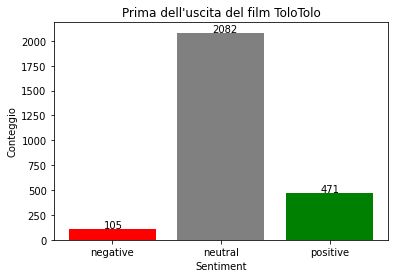

In [0]:
bars = plt.bar(rapportoDic_pol['polarity'],rapportoDic_pol['count'],color=['red','gray','green'])
plt.title("Prima dell'uscita del film ToloTolo")
plt.xlabel('Sentiment')
plt.ylabel('Conteggio')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.32, yval + 10, yval)

plt.savefig('drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/plot/primaFilm_totale.png')

In [0]:
rapportoGen_pol = pd.DataFrame(rapportoGen.groupby('polarity')['count'].sum()).reset_index(drop=False)

In [0]:
rapportoGen_pol

,polarity,count
0,negative,1191
1,neutral,11062
2,positive,6659


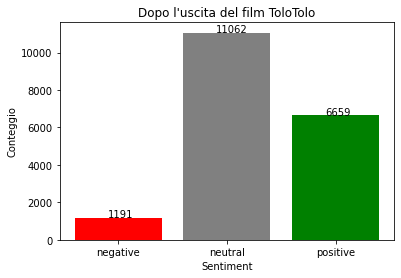

In [0]:
bars = plt.bar(rapportoGen_pol['polarity'],rapportoGen_pol['count'],color=['red','gray','green'])
plt.title("Dopo l'uscita del film ToloTolo")
plt.xlabel('Sentiment')
plt.ylabel('Conteggio')

for bar in bars:
    yval = bar.get_height()
    plt.text(bar.get_x() + 0.30, yval + 10, yval)

plt.savefig('drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/plot/dopoFilm_totale.png')

In [0]:
rapportoDic['momento']='prima'
rapportoGen['momento']='dopo'

### Prima uscita film

In [0]:
pos = rapportoDic[rapportoDic['polarity']=='positive']['count']
neg = rapportoDic[rapportoDic['polarity']=='negative']['count']
neu = rapportoDic[rapportoDic['polarity']=='neutral']['count']
giorni = rapportoDic['day'].unique()

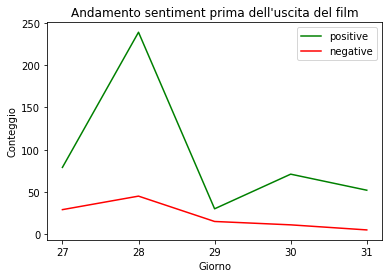

In [0]:
fig, ax= plt.subplots()
plt.locator_params(axis='x',nbins=5)
plt.plot(giorni,pos,color='green',label='positive')
plt.plot(giorni,neg,color='red',label='negative')
plt.title("Andamento sentiment prima dell'uscita del film")
plt.xlabel("Giorno")
plt.ylabel("Conteggio")
plt.legend()

plt.savefig('drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/plot/primafilm_giorno.png')

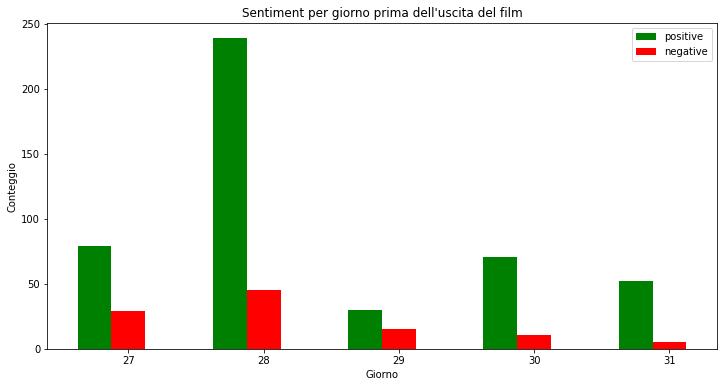

In [0]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(giorni))

bar_width = 0.25

plt.bar(x,pos,width=bar_width,color='green',label='positive')
plt.bar(x+bar_width,neg,width=bar_width, color='red',label='negative')
plt.xticks(x+bar_width*1,giorni)
plt.title("Sentiment per giorno prima dell'uscita del film")
plt.xlabel('Giorno')
plt.ylabel('Conteggio')
plt.legend()

### Dopo uscita film

In [0]:
pos = rapportoGen[rapportoGen['polarity']=='positive']['count']
neg = rapportoGen[rapportoGen['polarity']=='negative']['count']
neu = rapportoGen[rapportoGen['polarity']=='neutral']['count']
giorni = rapportoGen['day'].unique()

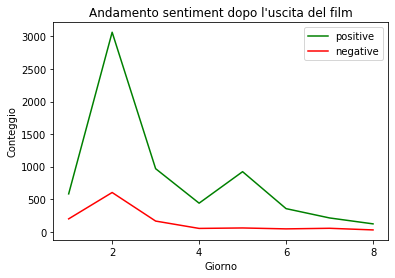

In [0]:
fig, ax= plt.subplots()
plt.locator_params(axis='x',nbins=7)
plt.plot(giorni,pos,color='green',label='positive')
plt.plot(giorni,neg,color='red',label='negative')
plt.title("Andamento sentiment dopo l'uscita del film")
plt.xlabel("Giorno")
plt.ylabel("Conteggio")
plt.legend()

plt.savefig('drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/plot/dopofilm_giorno.png')

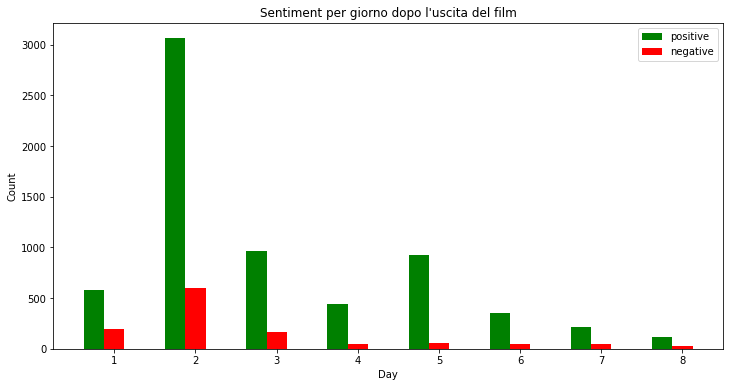

In [0]:
fig, ax = plt.subplots(figsize=(12, 6))
x = np.arange(len(giorni))

bar_width = 0.25

plt.bar(x,pos,width=bar_width,color='green',label='positive')
plt.bar(x+bar_width,neg,width=bar_width, color='red',label='negative')
plt.xticks(x+bar_width*1,giorni)
plt.title("Sentiment per giorno dopo l'uscita del film")
plt.xlabel('Day')
plt.ylabel('Count')
plt.legend()

### Analisi tweet sentiment

In [0]:
numeri = ris_df[['id_tweet','day','month','polarity']]

In [0]:
serie = pd.DataFrame(numeri[['day','month']])
serie = serie.drop_duplicates().sort_values(by='day',ascending=True)

In [0]:
index_gen = range(5,13,1)
index_dic = range(0,5,1)

index = list(itertools.chain(index_gen, index_dic))
serie['index'] = index

In [0]:
df_numeri = pd.DataFrame(numeri.groupby(['day','month','polarity'])['id_tweet'].count()).reset_index()
df_numeri = pd.merge(df_numeri,serie,on=['day','month'],how='inner')

In [0]:
df_numeri = df_numeri.sort_values(by='index',ascending=True)
df_numeri.columns = ['day','month','polarità','count','position']

In [0]:
df_numeri[(df_numeri['month']=='Dec') & (df_numeri['polarità']=='positive')].sum()

day         145                                     
month       DecDecDecDecDec                         
polarità    positivepositivepositivepositivepositive
count       471                                     
position    10                                      
dtype: object

In [0]:
df_numeri.groupby(['day','month'])['count'].sum()

day  month
1    Jan      1941
2    Jan      8895
3    Jan      3118
4    Jan      1300
5    Jan      1848
6    Jan      945 
7    Jan      544 
8    Jan      321 
27   Dec      311 
28   Dec      1203
29   Dec      344 
30   Dec      329 
31   Dec      471 
Name: count, dtype: int64

In [0]:
df_numeri.to_csv('drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/numeriTotale.csv')

# Analisi NER

In [0]:
df[['text','NER']]

In [0]:
df = pd.read_csv("drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/DatasetPreprocessato_noLemma.csv")
x = [ast.literal_eval(x) for x in df["NER"].tolist()]

def elimina_noise(x):
  if 'RitaPavone' in x:
    print(x)
    x.remove('RitaPavone')
  elif 'Greta' in x:
    print(x)
    x.remove('Greta')
  return x

['Greta', 'CheccoZalone']
['RitaPavone']
['RitaPavone']
['RitaPavone']
['Greta', 'CheccoZalone']
['Greta', 'CheccoZalone']
['RitaPavone']
['RitaPavone']
['Greta', 'CheccoZalone']
['Greta', 'CheccoZalone']
['RitaPavone']
['RitaPavone']
['RitaPavone']
['Greta', 'CheccoZalone']
['RitaPavone']
['RitaPavone']
['RitaPavone']
['RitaPavone']
['Greta', 'CheccoZalone']
['RitaPavone']
[('Checco Zalone', 11570), ('Matteo Salvini', 2121), ('Michela Murgia', 254), ('Giuseppe Conte', 158), ('Ignazio La Russa', 157), ('Maurizio Gasparri', 112), ('Franco Fantasia', 61), ('Alberto Sordi', 43), ('Roberto Beningni', 40), ('Beppe Grillo', 14), ('Massimo Boldi', 13), ('Adriano Celentano', 11), ('Giorgia Meloni', 10), ('Luigi Di Maio', 6)]
['navy', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'dodgerblue', 'lightseagreen', 'lightseagreen', 'lightseagreen', 'lightseagreen', 'lightseagreen', 'lightseagreen', 'lightseagreen', 'lightseagreen']


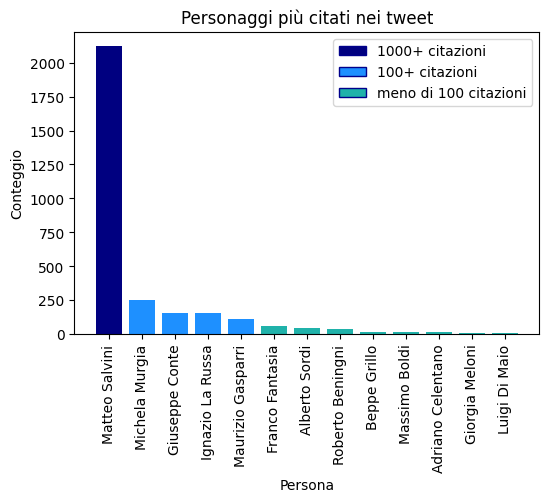

In [9]:
x = [ast.literal_eval(x) for x in df["NER"].tolist()]
x = list(map(elimina_noise,x))


data = Counter(list(itertools.chain.from_iterable(x))).most_common()
data

def getNorm(string):
  if(string == "CheccoZalone" or string=="Zalone" or string=="Checco" or string=="LucaMedici" or string=="Medici"):
    return "Checco Zalone"
  elif(string=="Salvini" or string=="MatteoSalvini" or string=="Matteo"):
    return "Matteo Salvini"
  elif (string == "LaRussa" or string=="IgnazioLaRussa"):
    return "Ignazio La Russa"
  elif (string == "Pozzetto" or string=="RenatoPozzetto"):
    return "Ignazio La Russa"
  elif (string == "Celentano" or string=="AdrianoCelentano"):
    return "Adriano Celentano"
  elif (string == "DIMAIO" or string=="LuigiDiMaio" or string=="Maio"):
    return "Luigi Di Maio"
  elif (string == "Pozzetto" or string=="RenatoPozzetto"):
    return "Renato Pozzetto"
  elif (string == "RitaPavone"):
    return "Rita Pavone"
  elif (string == "Conte"):
    return "Giuseppe Conte"
  elif (string == "BeppeGrillo" or string=="Grillo"):
    return "Beppe Grillo"
  elif (string == "AlbertoSordi" or string=="Sordi"):
    return "Alberto Sordi"
  elif (string=="Murgia"):
    return "Michela Murgia"
  elif (string=="Gasparri"):
    return "Maurizio Gasparri"
  elif (string=="Fantasia"):
    return "Franco Fantasia"
  elif (string=="Benigni" or string == "RobertoBenigni"):
    return "Roberto Beningni"
  elif (string=="Boldi" or string=="MassimoBoldi"):
    return "Massimo Boldi"
  elif (string=="GiorgiaMeloni" or string =="Meloni"):
    return "Giorgia Meloni"
  elif (string=="PaoloVillaggio" or string =="Villaggio"):
    return "Giorgia Meloni"
  elif (string=="Bologna" or string =="UgoBologna"):
    return "Ugo Bologna"
  else:
    return string
data = Counter(list(itertools.chain.from_iterable([[getNorm(x)]*y for x,y in data]))).most_common(14)
print(data)

import ast
import itertools
import matplotlib.pyplot as plt

def getColor(int):
  if int > 1000:
    return "navy"
  elif int < 1000 and int > 500:
    return "mediumblue"
  elif int < 260 and int > 100:
    return "dodgerblue"
  else:
    return "lightseagreen"
colors = [getColor(x[1]) for x in data[1:]]
print(colors)

plt.figure(dpi=100)
plt.title("Personaggi più citati nei tweet")
plt.bar([x[0] for x in data[1:]],[y[1] for y in data[1:]],color=colors)
from matplotlib.patches import Patch
from matplotlib.lines import Line2D
legend_ = [ Patch(facecolor='navy', edgecolor='darkblue', label='1000+ citazioni'), 
            Patch(facecolor='dodgerblue', edgecolor='darkblue', label='100+ citazioni'),
            Patch(facecolor='lightseagreen', edgecolor='darkblue', label='meno di 100 citazioni'),
           ]
plt.legend(handles=legend_,bbox_to_anchor=(1.,1.))
plt.xlabel('Persona')
plt.ylabel('Conteggio')

plt.xticks(rotation=90)

plt.savefig('drive/My Drive/SOCIAL MEDIA ANALYTICS/Progetto/plot/analisiNER.png')